## Set-up

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from pprint import pprint
import re
from tqdm import tqdm
tqdm.pandas()
import numpy as np

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=12, progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#!pwd
import os

# Google Bucket
# file name checkpoint_0512_sent_split.parquet
path_bucket = 'gs://msca-sp23-bucket/nlp_data'
bucket_read = path_bucket + '/' + 'checkpoint_0523_cleaned_filtered_data.parquet'
runtime_path = '/home/anthony/projects/nlp_runtime'

os.chdir(runtime_path)
print(os.getcwd())

/home/anthony/projects/nlp_runtime


In [3]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore")

In [4]:
import seaborn as sns
#sns.set()
import matplotlib.pyplot as plt

In [5]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [6]:
import spacy
#import spacy.cli

2023-05-24 18:19:23.548006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 18:19:30.829046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
#spacy.cli.download("en_core_web_md")
import en_core_web_md
nlp = spacy.load("en_core_web_md")

In [8]:
# read data
df_raw = pd.read_parquet(bucket_read, engine='pyarrow')

In [9]:
# take a sample
df = df_raw.sample(50000, random_state=42)

print(f'raw data shape{df_raw.shape}')
print(f'sample shape{df.shape}')
df.head(1)

raw data shape(185479, 4)
sample shape(50000, 4)


,url,date,title,text_cleaned
95601,https://www.wkyt.com/prnewswire/2022/06/14/windwards-first-of-its-kind-ai-model-creates-new-standard-eta-prediction-accuracy-critical-mitigating-supply-chain-disruptions/,2022-06-14,Windward's First-of-its-Kind AI Model Creates a New Standard of ETA Prediction Accuracy Critical to Mitigating Supply Chain Disruptions,Windward's First of its Kind AI Model Creates a New Standard of ETA Prediction Accuracy Critical to Mitigating Supply Chain Disruptions Skip to NewscastsEveryday Health DivideWKYT CamsClosings Championship 2022All BlueHigh School Game TimeMingua s Athlete of the WeekSports s Corner Off the BenchContact UsSubmit a News TipMeet the TeamAdvertising InformationJobs at WKYTNews AlertsSubmit Photos and VideosGray DC BureauInvestigate TVCommunityAloha MondaysBG H G TV of KindnessCommuni...


## LDA, on overall topics

Special thanks and reference to:

Terek Ghanoum, [Topic Modelling in Python with spaCy and Gensim](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf)

### Text Prep

I want to utilize parallelization as much as possile to save time

In [10]:
# keep top 40% of the text_cleaned
df['text_lda'] = df['text_cleaned'].progress_apply(lambda x: x[:int(len(x)*0.4)])

100%|██████████| 50000/50000 [00:00<00:00, 233094.59it/s]


## Sample LDA (n=50000) for best # of topics tuning

In [11]:
%%time

# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

for summary in nlp.pipe(df['text_lda'], n_process=12):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

CPU times: user 4min 52s, sys: 13.4 s, total: 5min 5s
Wall time: 6min 50s


In [12]:
df['tokens'] = tokens
df['tokens'].head()

95601     [windward, kind, ai, model, create, new, standard, eta, prediction, accuracy, critical, mitigating, supply, chain, disruption, skip, newscastseveryday, health, dividewkyt, camsclosings, championship, bluehigh, school, game, timemingua, athlete, weeksports, corner, benchcontact, ussubmit, news, tipmeet, teamadvertising, informationjobs, wkytnew, alertssubmit, photos, videosgray, dc, bureauinvestigate, h, g, tv, kindnesscommunity, starssponsored, storieswkyt, summer, grillin, sponsor, listings...
176291    [engineer, claim, google, ai, thought, feeling, place, leave, arttv, seriesbooks, dancebehind, viral, videosperforming, artstv, musichip, healthhealth, servicesmental, healthdiseases, healthcancerfood, sportspremier, drinkspetsbeauty, safetypublic, advicefamily, rentlabor, issuestrouble, scienceearth, nationsmiddle, location, channel, topic, people, inwate, k, k, m, viewsaboutwate, provide, late, news, weather, sport, coverage, knoxville, east, tennessee, peoplepersontony, ar

In [13]:
# apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df['tokens'])

In [14]:
# save a checkpoint
df.to_parquet('checkpoint_0524_lda_data.parquet', engine='pyarrow')

In [15]:
#print(dictionary.token2id)

In [16]:
# filter words with extreme frequency
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [17]:
# now we are able to construct the corpus
# function doc2bow() simply counts the number of occurrences of each distinct word,
# --> converts teh word to its ineger word id and returns the results as a sparse vector

corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

In [18]:
# # train a simple LDA model
# lda_model = LdaMulticore(corpus=corpus, 
#                          id2word=dictionary, 
#                          iterations=50, 
#                          num_topics=10, 
#                          workers = 12, 
#                          passes=10)

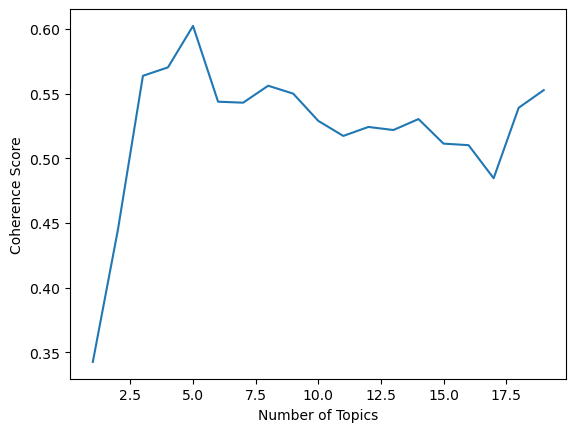

CPU times: user 14min 34s, sys: 1min 19s, total: 15min 53s
Wall time: 26min 45s


In [19]:
%%time

# Tuning for best LDA topics
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 12, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_ = plt.plot(topics, score)
_ = plt.xlabel('Number of Topics')
_ = plt.ylabel('Coherence Score')
plt.show()

In [20]:
# save topics and score in to a dataframe
#df_score = pd.DataFrame({'topics':topics, 'score':score})
#df_score.to_csv('checkpoint_lda_tuning_cohenrence_score.csv', index=False)

# read the score
#df_score = pd.read_csv('checkpoint_lda_tuning_cohenrence_score.csv')

## Full sample LDA

In [8]:
# read data
#df_raw = pd.read_parquet(bucket_read, engine='pyarrow')

# take a sample
df = df_raw #.sample(50000, random_state=42)

print(f'raw data shape{df_raw.shape}')
print(f'sample shape{df.shape}')
df.head(1)

raw data shape(185479, 4)
sample shape(185479, 4)


,url,date,title,text_cleaned
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. So..."


In [9]:
# keep top 40% of the text_cleaned
df['text_lda'] = df['text_cleaned'].parallel_apply(lambda x: x[:int(len(x)*0.4)])

In [10]:
%%time

# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

for summary in nlp.pipe(df['text_lda'], n_process=12):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

CPU times: user 17min 49s, sys: 48.5 s, total: 18min 37s
Wall time: 24min 27s


In [ ]:
# add token back to df
df['tokens'] = tokens

# apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df['tokens'])

# save a checkpoint
#df.to_parquet('checkpoint_0524_lda_data.parquet', engine='pyarrow')

In [11]:
# filter words with extreme frequency
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# construct corpus
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

### 5 topics

In [13]:
# LDA model with best # of topics
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=50, 
                         num_topics=5, 
                         workers = 12, 
                         passes=10)

In [14]:
lda_model.print_topics(-1)

[(0,
  '0.015*"chatgpt" + 0.011*"say" + 0.009*"google" + 0.009*"s" + 0.008*"search" + 0.007*"video" + 0.006*"microsoft" + 0.006*"openai" + 0.006*"use" + 0.006*"tv"'),
 (1,
  '0.013*"platform" + 0.013*"datum" + 0.011*"customer" + 0.011*"solution" + 0.009*"machine" + 0.009*"announce" + 0.009*"business" + 0.009*"learning" + 0.008*"data" + 0.008*"weather"'),
 (2,
  '0.106*"market" + 0.040*"report" + 0.030*"global" + 0.024*"analysis" + 0.022*"growth" + 0.018*"industry" + 0.015*"research" + 0.015*"forecast" + 0.014*"key" + 0.009*"business"'),
 (3,
  '0.011*"datum" + 0.010*"health" + 0.008*"research" + 0.008*"system" + 0.007*"science" + 0.007*"use" + 0.007*"say" + 0.007*"e" + 0.006*"machine" + 0.006*"patient"'),
 (4,
  '0.026*"services" + 0.023*"business" + 0.019*"best" + 0.018*"financial" + 0.018*"consumer" + 0.017*"stock" + 0.015*"products" + 0.014*"real" + 0.014*"ment" + 0.013*"estate"')]

In [15]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

### 8 topics

In [12]:
# LDA model with best # of topics
lda_model_t8 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=50, 
                         num_topics=8, 
                         workers = 12, 
                         passes=10)

In [13]:
lda_model_t8.print_topics(-1)

[(0,
  '0.016*"health" + 0.016*"weather" + 0.014*"music" + 0.014*"platform" + 0.013*"alert" + 0.012*"country" + 0.012*"skip" + 0.012*"dc" + 0.011*"solution" + 0.010*"announce"'),
 (1,
  '0.041*"chatgpt" + 0.025*"google" + 0.020*"microsoft" + 0.018*"openai" + 0.015*"chatbot" + 0.015*"user" + 0.012*"search" + 0.012*"say" + 0.011*"language" + 0.010*"pany"'),
 (2,
  '0.031*"services" + 0.022*"consumer" + 0.022*"business" + 0.020*"products" + 0.019*"ment" + 0.017*"financial" + 0.016*"transportation" + 0.016*"computer" + 0.016*"real" + 0.015*"estate"'),
 (3,
  '0.020*"business" + 0.017*"data" + 0.015*"best" + 0.015*"datum" + 0.011*"digital" + 0.010*"customer" + 0.010*"cloud" + 0.009*"service" + 0.009*"security" + 0.009*"management"'),
 (4,
  '0.109*"market" + 0.041*"report" + 0.030*"global" + 0.025*"analysis" + 0.023*"growth" + 0.018*"industry" + 0.016*"research" + 0.015*"forecast" + 0.015*"key" + 0.010*"study"'),
 (5,
  '0.026*"stock" + 0.024*"trade" + 0.016*"fund" + 0.014*"share" + 0.013*"

In [14]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model_t8, corpus, dictionary)
pyLDAvis.display(lda_display)

### Decide Topics and add back to dataframe

With 5-topics-LDA model, we can identify the following topics:
- Generative AI associated with ChatGPT, Chatbot, ImageGeneration; associated firms are: Microsoft, OpenAI
- Healthcare solution with music, clinical photos, hourly patien alerts
- Application of machine learning and computer vision associated with nvidia
- Global impact on market and industry, as well as forecast on market growth
- Finanacial investment in consumer services/products, real estate, manufacturing, electronics, etc

In [17]:
df['topic'] = [sorted(lda_model_t8[corpus][text])[0][0] for text in range(len(df['text_cleaned']))] # maybe title is better

In [42]:
df[['text_cleaned','topic']].head(5)

,text_cleaned,topic
0,"Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. So...",0
1,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot Author Recent Posts admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall? February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the nex...",6
2,"Forget ML, AI and Industry 4.0 obsolescence should be your focus 26 February 2021 Test Rework Solutions Dataweek Home About us Back issues / E book / PDF EMP Handbook Subscribe Advertise Editor's Choice Multimedia, Videos Analogue, Mixed Signal, LSI Circuit System Protection Computer/Embedded Technology Design Automation DSP, Micros Memory Electronics Technology Enclosures, Racks, Cabinets Panel Products Events Interconnection Manufacturing / Productio...",2
3,"Strategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered Consumer Electronics Net Skip to content Search for: HomeNewsStrategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered News Strategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered 7 hours ago BOSTON BUSINESS WIRE Strategy Analytics in a newly published report, S...",1
4,"Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application IT Business Net Skip to content Search for: to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application News Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application TOKYO, Oct 2...",0


In [19]:
df.topic.value_counts()

topic
0    74015
1    44223
2    22526
3    20102
4    12858
6     5937
5     5224
7      594
Name: count, dtype: int64

I got curious about why 'music' is in the topic 5. Let's take a look.

In [44]:
# looking at topic 5, but the index is 4
df_tmp = df[(df.topic == 4) & (df.title.str.contains('music'))][['text_cleaned', 'url', 'topic']]
df_tmp.head()

,text_cleaned,url,topic
71697,"Tolerance.ca Inside the music industry's battle with the UK government over AI song generators Director / Editor: Victor Teboul, Ph.D. Looking inside ourselves and out at the world Independent and neutral with regard to all political and religious orientations, Tolerance.ca aims to promote awareness of the major democratic principles on which tolerance is based. Fran ais Looking inside ourselves and out at the world Independent and neutral with regard to all political a...",https://www.tolerance.ca/ArticleExt.aspx?ID=530387&L=en,4
74216,"Australian song called Beautiful the World wins AI petition KidsNews Brought to you by Newscorp Australia KIDS NEWS NewsSportKey for KidsArtsEducation KitsSpelling BeeLearning at Home Reading Levels Green Orange Red Aussie AI song takes global music prize Claire Slattery, May 14, 2020 6:45PM Print Article An Australian song written using artificial intelligence has won a new international petition. The song, Beautiful the World, was one of 13 entries in the AI Song C...",https://www.kidsnews.com.au/technology/aussie-ai-song-takes-global-music-prize/news-story/1db1c737a4268f7d09ebee003bb13d95,4
85233,"Grimes' ed the use of her voice in AI music, sparking legal questions KGOU Search Query Show Search Home Listen Listening Options Listening Options News KGOU News Capitol Insider KGOU AM NewsBrief KGOU PM NewsBrief Oklahoma Watch Oklahoma Watch: Long Story Short National Weather Service Forecast KGOU Archive KGOU News Capitol Insider KGOU AM NewsBrief KGOU PM NewsBrief Oklahoma Watch Oklahoma Watch: Long Story Short National Weather Service Forecast KGOU Archive Programs Shows and Podcas...",https://www.kgou.org/science-technology-and-environment/science-technology-and-environment/2023-04-27/grimes-welcomed-the-use-of-her-voice-in-ai-music-sparking-legal-questions,4
161080,Imogen Heap: How AI is helping to push music creativity BBC News linksSkip to HelpBBC the BBCSearch the BBC News BBC News Navigation Sections Home Imogen Heap: How AI is pushing music creativity Jump to media player The singer songwriter explains why she is using artificial intelligence to help her produce music. 15 Apr Share this with Facebook Share this with Messenger Share this with Twitter Share this with Email Share this with Facebook Share this with WhatsApp Share this with M...,https://www.bbc.com/news/av/technology-52236563/imogen-heap-how-ai-is-helping-to-push-music-creativity,4


It turns out to be AI-generated songs and the associated conflicts with creators (musicians, singers) and streaming platform (Spotify)

In [20]:
# df.to_parquet('checkpoint_0524_lda_data_lda_8_topics.parquet', engine='pyarrow')

In [45]:
# save a copy at bucket
bucket_write = path_bucket + '/' + 'checkpoint_0524_lda_data_lda_8_topics.parquet'
df.to_parquet(bucket_write, index=False, engine='pyarrow')

In [ ]:
df = pd.read_parquet('checkpoint_0524_lda_data_lda_5_topics.parquet', engine='pyarrow')
df.head()

In [47]:
# save a copy at bucket
bucket_write = path_bucket + '/' + 'checkpoint_0524_lda_data_lda_5_topics.parquet'
df.to_parquet(bucket_write, index=False, engine='pyarrow')